In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from mpl_toolkits.mplot3d import Axes3D
from noisyopt import minimizeSPSA

In [2]:
class Model():
    def __init__(self, pred_die=0.02, pred_repr=0.5, prey_repr=0.9, step_size = 100):
        # grid dimensions
        self.width = 100
        self.height = 100
        
        # the values of different states of cells (containing predator, prey or none) 
        self.empty_val = 0
        self.pred_val = 1
        self.prey_val = 2
        
        self.pred_die_probability = pred_die
        self.pred_reproduce_probability = pred_repr
        self.prey_reproduce_probability = prey_repr
        self.step_size = step_size

        self.coordinates = []
        for y in range(self.height):
            for x in range(self.width):
                self.coordinates.append((y, x))
                
        self.error = 0
        
        # define starting population
        n_pred_start = 500
        n_prey_start = 1000
        self.n_pred = n_pred_start
        self.n_prey = n_prey_start
        
        # init grid
        grid_flat = np.zeros(self.width*self.height)
        grid_flat[0:n_pred_start] = self.pred_val
        grid_flat[n_pred_start:n_pred_start+n_prey_start] = self.prey_val
        np.random.shuffle(grid_flat)
        self.grid = np.reshape(grid_flat, (self.height, self.width))
        
    def select_random_neighbor(self, coordinates):
        y = (coordinates[0] + (np.random.randint(3) - 1)) % self.height
        x = (coordinates[1] + (np.random.randint(3) - 1)) % self.width
        return (y, x)

    def step_grid(self):
        np.random.shuffle(self.coordinates)
        for coordinate in self.coordinates:
            value = self.grid[coordinate]
            if value == self.empty_val:
                continue
            else:
                neighbor_coordinate = self.select_random_neighbor(coordinate)
                neighbor_val = self.grid[neighbor_coordinate]
                if value == self.pred_val:
                    # predator
                    if neighbor_val == self.empty_val:
                        # die maybe
                        self.grid[coordinate] = self.empty_val
                        self.n_pred -= 1
                        if np.random.rand() > self.pred_die_probability:
                            # move (do not die)
                            self.grid[neighbor_coordinate] = self.pred_val
                            self.n_pred += 1
                    if neighbor_val == self.prey_val:                        
                        self.n_prey -= 1
                        if np.random.rand() < self.pred_reproduce_probability:
                            # eat and reproduce in prey's cell
                            self.grid[neighbor_coordinate] = self.pred_val
                            self.n_pred += 1
                        else:
                            # only eat prey
                            self.grid[neighbor_coordinate] = self.empty_val
                elif value == self.prey_val:
                    # prey
                    if neighbor_val == self.empty_val:
                        # (reproduce to/) move to new cell
                        self.grid[neighbor_coordinate] = self.prey_val
                        self.n_prey += 1
                        if np.random.rand() > self.prey_reproduce_probability:
                            # (do not reproduce/ kill old cell)
                            self.grid[coordinate] = self.empty_val
                            self.n_prey -= 1
                    if neighbor_val == self.pred_val:
                        self.n_prey -= 1
                        if np.random.rand() < self.pred_reproduce_probability:
                            # eat and reproduce to prey's cell
                            self.grid[coordinate] = self.pred_val
                            self.n_pred += 1
                        else:
                            # only eat prey
                            self.grid[coordinate] = self.empty_val

                            
    def run_model(self):
        pred_population = []
        prey_population = []
        for i in trange(self.step_size):
            pred_population.append(self.n_pred)
            prey_population.append(self.n_prey)
            if self.n_prey == 0 or self.n_pred == 0:
                break
            self.step_grid()
        plt.plot(pred_population, label="predators")
        plt.plot(prey_population, label="prey")
        plt.legend()
        self.objective_function((pred_population, prey_population))
        return (pred_population, prey_population)
    
    def objective_function(self, time_series):
        if len(time_series[0]) != self.step_size or len(time_series[1]) != self.step_size:
            return 1000000000
        mean_0 = np.mean(time_series[0])
        mean_1 = np.mean(time_series[1])
        cost = 0
        for i in range(len(time_series[0])):
            cost += (time_series[0][i] - mean_0)**2
            cost += (time_series[1][i] - mean_1)**2
        self.error = cost
        return cost
        



[123240997.8]

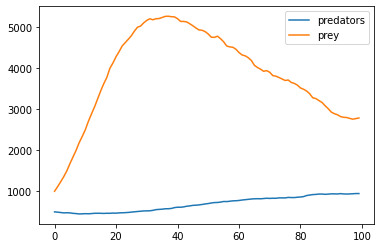

In [3]:
trials = 1
errors = []
for i in trange(trials):
    model = Model(0.02, 0.05, 0.2, 100)
    model.run_model()
    errors.append(model.error)
errors

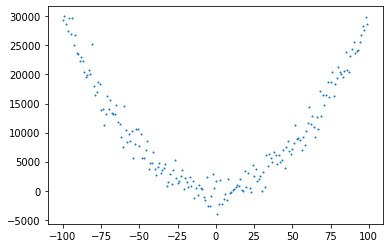

In [4]:
def func3(a, b, c):
    return a**2+b**2+c**2+np.random.normal(0, 1500, len(a))

x = np.arange(-100, 100, 1)
y = func3(x, x, x)

plt.plot(x, y, 'o', markersize=1)


In [5]:
cost_variability = []
for i in range(len(errors)):
    cost_variability.append(abs(1-(errors[i]/np.mean(errors))))
print(cost_variability)

[0.0]


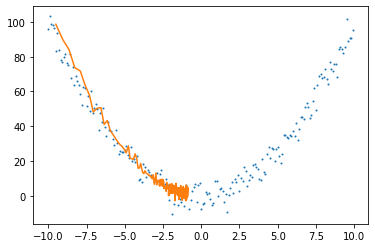

In [16]:
def func1_list(x):
    return x**2 + np.random.normal(0, 5, len(x)) 

def func1(x):
    return x**2+np.random.normal(0, 2) 

x = np.arange(-10, 10, 0.1)
y = func1_list(x)
plt.plot(x, y, 'o', markersize = 1)
# plt.show()
# hold on

def basic_robbins_monro(f, starting_point, learning_rate, iterations=200):
    x = starting_point
    x_list = []
    y_list = []
    for i in range(iterations):
        if x > 1000 or x < -1000:
            break
#         print(x)
        y = f(x)
        x = x-learning_rate*y
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list
        
x_list, y_list = basic_robbins_monro(func1, -10, -0.005)
plt.plot(x_list, y_list)

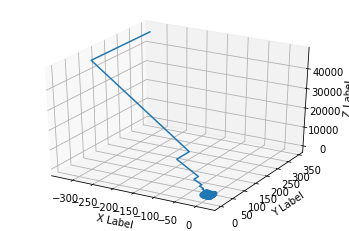

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def func1(x, y):
    return (2*x)**2+(y+5)**2+np.random.normal(0, 6) 

x_list = np.arange(-10, 10, 1)
y_list = np.arange(-10, 10, 1)

zs = []
xs = []
ys = []

for i in range(len(x_list)):
    for j in range(len(y_list)):
        xs.append(i)
        ys.append(j)
        zs.append(func1(x_list[i], y_list[j]))

        
ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

def basic_robbins_monro_md(f, x_start, y_start, learning_rate, iterations=200):
    x = x_start
    y = y_start
    x_list = []
    y_list = []
    z_list = []
    for i in range(iterations):
        if x > 100 or x < -100:
            break
#         print(x)
        z = f(x, y)
        x = x-learning_rate*z
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
        y = y+learning_rate*z
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
    return x_list, y_list, z_list


xs, ys, zs = basic_robbins_monro_md(func1, 5, 10, 0.005)
ax.plot(xs, ys, zs)

(100,)
(100,)
(100,)


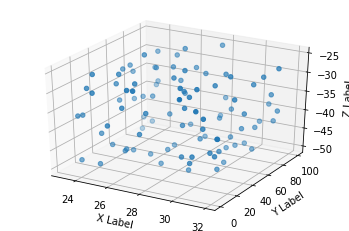

[-38.94278242 -44.49836553 -30.46230397 -38.7992772  -47.97489312
 -47.79266375 -37.04015356 -26.41325166 -26.50351578 -32.54205257
 -29.19452384 -28.90852798 -36.80630297 -46.25337673 -47.57891725
 -25.70963501 -48.1242674  -42.46353024 -49.97830505 -30.72187616
 -32.93429756 -38.82023019 -30.16852191 -41.18362452 -41.60458141
 -41.66317713 -44.30072178 -33.9302833  -47.2583366  -42.28039221
 -48.04764933 -26.79310285 -25.43124559 -36.95547664 -38.32940325
 -29.85251263 -32.7196556  -44.65664915 -34.83825092 -37.88407078
 -48.06937209 -37.84189326 -25.38460372 -32.38514932 -31.09871342
 -41.57743801 -28.70640316 -26.81071377 -42.54072128 -36.76015291
 -33.10301098 -37.4361001  -44.02115834 -43.11569076 -27.01599227
 -28.70815156 -31.36317966 -35.25063099 -30.07745664 -29.68750776
 -37.97730232 -43.66739419 -27.39678501 -29.43638867 -39.020431
 -29.97431228 -45.75415625 -28.58836908 -29.85823312 -45.65010898
 -49.83081686 -27.49728642 -42.41072457 -38.80325897 -31.55970036
 -47.1808612

In [8]:
def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
xs = randrange(n, 23, 32)
ys = randrange(n, 0, 100)
zs = randrange(n, -50, -25)
ax.scatter(xs, ys, zs, marker='o')

print(xs.shape)
print(ys.shape)
print(zs.shape)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
print(zs)

In [22]:
def func1_list(x):
    return x**2 + np.random.normal(0, 5, len(x)) 

def func1(x):
    return x**2+np.random.normal(0, 2) 

x = np.arange(-10, 10, 0.1)
y = func1_list(x)
# plt.plot(x, y, 'o', markersize = 1)
# plt.show()
# hold on

def basic_robbins_monro(f, starting_point, a, c, iterations=200):
    x = starting_point
    x_list = []
    y_list = []
    for i in range(iterations):
        if x > 1000 or x < -1000:
            break
#         print(x)
        x = x-a(f(x+c)-f(x-c))
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list
        
# x_list, y_list = basic_robbins_monro(func1, -10, -0.005)
# plt.plot(x_list, y_list)

for i in range(10):
    basic_robbins_monro(func1, -10, -0.005)